In [1]:
'''Importing packages and functions''' 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
from numpy.linalg import inv
from pandas_datareader.data import DataReader 
from scipy import signal
from scipy.optimize import root
from statsmodels.tsa.api import VAR, AR
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
'''Matplotlib+Latex config'''

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

****

In [3]:
def objective(x0, Mhat, Omegahat, num_vars): 
    
    '''
    Objective function to impose restrictions on the 
    variance covariance matrix of the estimated reduced form, 
    starts with x0, outputs H, which it uses again as x0 
    until convergence.
    
    It grabs starting values, and create a possible matrix A(0).
    LR effect given by multiplication of Mhat and A0.
    A(0)*A(0).T should be equal to Omegahat, as variance of 
    shocks is identity. 
    We add LR restriction.
    
    Each parameter in H must be equal to 0, including LR restriction.
    '''
    
    A0     = np.reshape(x0,[num_vars,num_vars])
    LR     = Mhat@A0
    H      = A0@A0.T - Omegahat
    H[0,1] = LR[0,1]
    H      = H.flatten()
    
    return H 

****

# *1.2.*

In [4]:
'''Downloading and preparing data using DataReader'''

#Sample selection
start, end = '1948Q1', '1987Q3'

#Data from FRED
gdp   = DataReader('GNPC96', 'fred', start=start,  end=end) # Q frequency
urate = DataReader('UNRATE', 'fred', start=start, end=end)  # M frequency

In [5]:
'''Transforming the data'''

#Frequency change for urate
urateq = urate.resample('Q').mean()

#From YYYYQ format to date format (find it important for matplotlib)
gdp.index    = pd.date_range(start,'1987Q4',freq="Q")
urateq.index = pd.date_range(start,'1987Q4',freq="Q")

#Create Frame
df          = pd.concat((urateq, gdp), axis=1)
df.columns  = ["urate","gdp"]
df["lngdp"] = np.log(df["gdp"])
df["dy"]    = (df["lngdp"] - df["lngdp"].shift(1))*400 # Annualized
df          = df[1:]                                   # Drop first observation

# Detrending as in the paper: Important to make the data covariance stationary
df.loc[:"1973Q2","dys"] = signal.detrend(df.loc[:"1973Q2","dy"],type="constant")
df.loc["1973Q3":,"dys"] = signal.detrend(df.loc["1973Q3":,"dy"],type="constant")
df["urates"]            = signal.detrend(df["urate"])

#Setting up the data for VAR
X = df.loc[:,["dys","urates"]].copy()

In [6]:
'''Estimation'''

#Constructing the matrix of lags
XLAG     = pd.DataFrame()
num_lags = 8 
for i in range(1,num_lags+1):
    XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)

#Change names to frames that we modify    
X2                = X.iloc[num_lags:,:]
XLAG2             = XLAG.iloc[num_lags:,:]
num_obs, num_vars = X2.shape

#Building arrays for using OLS
X3, XLAG3 = [np.array(i) for i in [X2, XLAG2]]

#VAR - standard OLS
Bhat = inv(XLAG3.T@XLAG3)@XLAG3.T@X3

#Estimated errors
EPS = (X3 - XLAG3@Bhat)

#estimated covariance matrix
Omegahat = EPS.T@EPS/(num_obs - num_lags*num_vars)

# Putting problem in canonical form (VAR(8) into VAR(1))
c_Bhat = np.vstack((Bhat.T,
                    np.hstack((np.identity((num_lags-1)*num_vars),
                               np.zeros([(num_lags-1)*num_vars,num_vars])))
                   )) 

#Setting up for LR restriction
c_Mhat = inv(np.identity(c_Bhat.shape[0])-c_Bhat)
Mhat   = c_Mhat[:2,:2]

In [7]:
'''Solving the system of equation to find the structural parameters'''

#Starting values, flatten is needed for root function below
x0 = ((Omegahat**2)**.25).flatten() 

#Solve F(X) = 0, where both X and 0 can be vectors
#returns the values of G, A(0), which guarantee LR restriction = 0,
#as well as the information from variance-covariance matrix
sol = root(objective, x0, args=(Mhat,Omegahat,num_vars)) 
A0   = sol.x.reshape([num_vars,num_vars]) 

#the first shock (supply) should have a positive impact on output 
#(only redefines direction, and changes nothing)
if A0[0,0] < 0: A0[:,0] = -A0[:,0]

#the second shock (demand) should have a positive impact on output 
#(only redefines direction, and changes nothing)
if A0[0,1] < 0: A0[:,1] = -A0[:,1]

#Estimating structural shocks, ETA
F   = inv(A0)
ETA = EPS@F.T

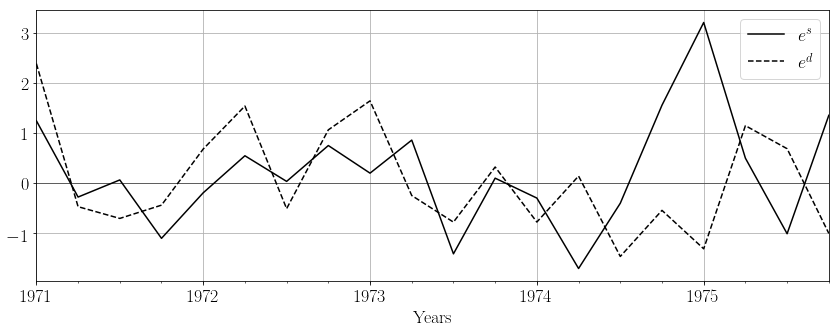

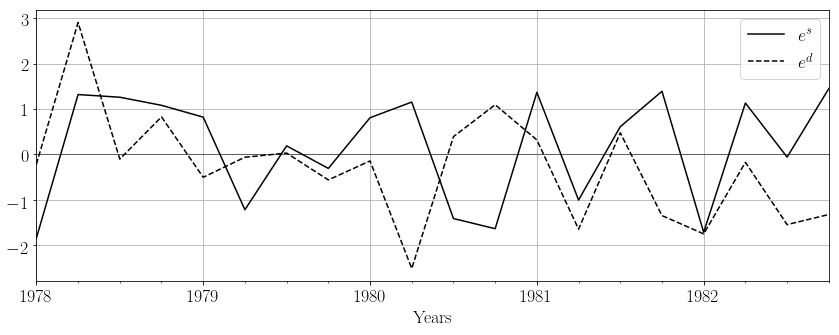

\begin{tabular}{lrr}
\toprule
{} &        es &        ed \\
\midrule
1971Q1 &  1.241720 &  2.383078 \\
1971Q2 & -0.282434 & -0.474974 \\
1971Q3 &  0.059526 & -0.709511 \\
1971Q4 & -1.107234 & -0.444346 \\
1972Q1 & -0.197717 &  0.676676 \\
1972Q2 &  0.542377 &  1.535791 \\
1972Q3 &  0.030230 & -0.514403 \\
1972Q4 &  0.746675 &  1.059869 \\
1973Q1 &  0.194915 &  1.639074 \\
1973Q2 &  0.855159 & -0.252065 \\
1973Q3 & -1.416938 & -0.783273 \\
1973Q4 &  0.094650 &  0.317641 \\
1974Q1 & -0.302911 & -0.781594 \\
1974Q2 & -1.709881 &  0.137094 \\
1974Q3 & -0.406280 & -1.469462 \\
1974Q4 &  1.552633 & -0.548591 \\
1975Q1 &  3.205074 & -1.316494 \\
1975Q2 &  0.494245 &  1.143979 \\
1975Q3 & -1.015008 &  0.683304 \\
1975Q4 &  1.350854 & -1.008734 \\
\bottomrule
\end{tabular}
 

\begin{tabular}{lrr}
\toprule
{} &        es &        ed \\
\midrule
1978Q1 & -1.844734 & -0.218162 \\
1978Q2 &  1.316817 &  2.903624 \\
1978Q3 &  1.257999 & -0.103847 \\
1978Q4 &  1.079911 &  0.825002 \\
1979Q1 &  0.81971

In [8]:
'''Output'''

q12 = pd.DataFrame(ETA, index=X.index[num_lags:], columns=["es", "ed"])
q12.index = q12.reset_index()["index"].dt.to_period('Q').values

for i, x in enumerate([['1971', '1975'], ['1978', '1982']]):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))#; axes = axes.flatten()
    q12.loc[x[0]:x[1]].plot(color="k", style=["-", "--"], ax=ax)
    ax.legend([r"$e^s$", r"$e^d$"])
    ax.set_xlabel('Years')
    #ax.set_title("Structural Shocks: %s-%s" % (x[0], x[1]))
    ax.grid()
    ax.axhline(y=0, color="k", linewidth=0.5)
    plt.tight_layout()
    plt.savefig('./ps1/q12%s.png' % (i+1), bbox_inches='tight')
    plt.show()

print(q12.loc["1971":"1975"].to_latex(), "\n")
print(q12.loc["1978":"1982"].to_latex())

****

# *1.3*

In [9]:
'''Downloading and preparing data using DataReader'''

#Sample selection
start, end, endplus1 = '1948Q1', '2018Q4', '2019Q1'

#Data from FRED
gdp   = DataReader('GNPC96', 'fred', start=start, end=end)  # Q frequency
urate = DataReader('UNRATE', 'fred', start=start, end=end)  # M frequency

In [10]:
'''Transforming the data'''

#Frequency change for urate
urateq = urate.resample('Q').mean()

#From YYYYQ format to date format (find it important for matplotlib)
gdp.index    = pd.date_range(start, endplus1, freq="Q")
urateq.index = pd.date_range(start, endplus1, freq="Q")

#Create Frame
df          = pd.concat((urateq, gdp), axis=1)
df.columns  = ["urate","gdp"]
df["lngdp"] = np.log(df["gdp"])
df["dy"]    = (df["lngdp"] - df["lngdp"].shift(1))*400 # Annualized
df          = df[1:]                                   # Drop first observation

# Detrending as in the paper: Important to make the data covariance stationary
df["dys"]    = signal.detrend(df["dy"])
df["urates"] = signal.detrend(df["urate"])#, type="constant")

#Setting up the data for VAR
X = df.loc[:,["dys","urates"]].copy()

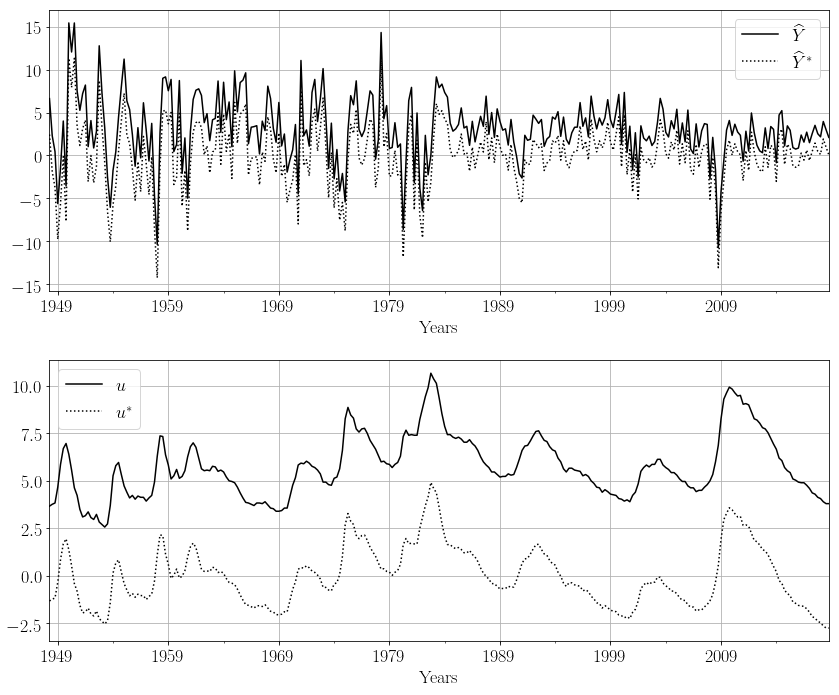

In [11]:
legend = [r"$\widehat{Y}$", "$u$"]
legend_detrended = [r"$\widehat{Y}^*$", r"$u^*$"]
f, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,10)); axes = axes.flatten()
for i, x in enumerate(["dy", "urate"]):
    df[[x, x+"s"]].plot(style=["k-", "k:"], ax=axes[i])
    axes[i].legend([legend[i], legend_detrended[i]])
    axes[i].set_xlabel('Years')
    axes[i].grid()
plt.tight_layout()
plt.savefig('./ps1/aq31.png', bbox_inches='tight')
plt.show()

In [12]:
'''Testing stationarity'''

for i, x in enumerate(["dys", "urates"]):
    print("="*26)
    print("Testing stationarity of %s" % ["ΔY", "u"][i], "\n"+"="*26)
    result = adfuller(df[x]) 
    print('ADF Statistic: %f' % result[0]) 
    print('p-value: %f' % result[1]) 
    print('Critical Values:') 
    for key, value in result[4].items(): 
        print('\t%s: %.3f' % (key, value))
    if i ==0: print("\n")
    # Growth rate of GDP seems stationary
    # u kinda seems stationary 

Testing stationarity of ΔY 
ADF Statistic: -8.672518
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


Testing stationarity of u 
ADF Statistic: -2.845394
p-value: 0.052076
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573


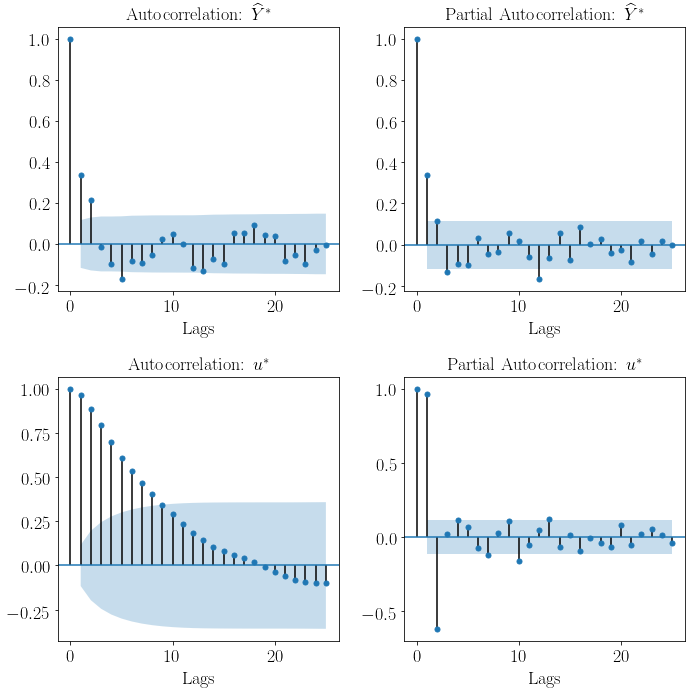

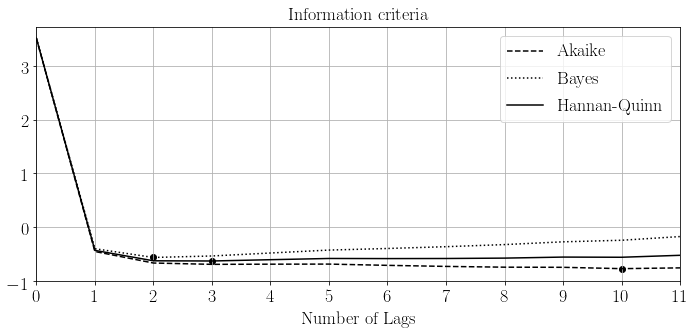

In [13]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10)); axes = axes.flatten()
for i, x in enumerate(["dys", "urates"]):
    plot_acf(df[x], lags=25, ax=axes[i*2], title="Autocorrelation: "+[r"$\widehat{Y}^*$", "$u^*$"][i])
    plot_pacf(df[x], lags=25, ax=axes[i*2+1], title="Partial Autocorrelation: "+[r"$\widehat{Y}^*$", "$u^*$"][i])
for i in axes: i.set_xlabel("Lags")
plt.tight_layout()
plt.savefig('./ps1/aq32.png', bbox_inches='tight')
plt.show()

print("\n")

IC = np.zeros((12,3))
for r in range(IC.shape[0]):
    mod = VAR(X).fit(r, trend='nc', )
    IC[r,:] = [mod.aic, mod.bic, mod.hqic]
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
for c in range(IC.shape[1]):
    xval, yval = np.where(IC[:,c]==np.amin(IC[:,c]))[0][0], np.amin(IC[:,c])
    ax.scatter(x=xval,y=yval, color="k")
IC = pd.DataFrame(IC, index=range(IC.shape[0]), columns=["Akaike", "Bayes", "Hannan-Quinn"])
IC.plot(style=['k--','k:','k-'], ax=ax)
ax.set_title("Information criteria")
ax.set_xlabel("Number of Lags")
ax.grid()
ax.xaxis.set_ticks(np.arange(0, 12, 1))
plt.tight_layout()
plt.savefig('./ps1/aq33.png', bbox_inches='tight')
plt.show()

In [14]:
'''Estimation'''

#Constructing the matrix of lags
XLAG     = pd.DataFrame()
num_lags = 10 # Akaike updated from 8->17
for i in range(1,num_lags+1):
    XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)

#Change names to frames that we modify    
X2                = X.iloc[num_lags:,:]
XLAG2             = XLAG.iloc[num_lags:,:]
num_obs, num_vars = X2.shape

#Building arrays for using OLS
X3, XLAG3 = [np.array(i) for i in [X2, XLAG2]]

#VAR - standard OLS
Bhat = inv(XLAG3.T@XLAG3)@XLAG3.T@X3

#Estimated errors
EPS = (X3 - XLAG3@Bhat)

#estimated covariance matrix
Omegahat = EPS.T@EPS/(num_obs - num_lags*num_vars)

# Putting problem in canonical form (VAR(8) into VAR(1))
c_Bhat = np.vstack((Bhat.T,
                    np.hstack((np.identity((num_lags-1)*num_vars),
                               np.zeros([(num_lags-1)*num_vars,num_vars])))
                   )) 

#Setting up for LR restriction
c_Mhat = inv(np.identity(c_Bhat.shape[0])-c_Bhat)
Mhat   = c_Mhat[:2,:2]

In [15]:
'''Solving the system of equation to find the structural parameters'''

#Starting values, flatten is needed for root function below
x0 = ((Omegahat**2)**.25).flatten() 

#Solve F(X) = 0, where both X and 0 can be vectors
#returns the values of G, A(0), which guarantee LR restriction = 0,
#as well as the information from variance-covariance matrix
sol = root(objective, x0, args=(Mhat,Omegahat,num_vars)) 
A0   = sol.x.reshape([num_vars,num_vars]) 

#the first shock (supply) should have a positive impact on output 
#(only redefines direction, and changes nothing)
if A0[0,0] < 0: A0[:,0] = -A0[:,0]

#the second shock (demand) should have a positive impact on output 
#(only redefines direction, and changes nothing)
if A0[0,1] < 0: A0[:,1] = -A0[:,1]

#Estimating structural shocks, ETA
F   = inv(A0)
ETA = EPS@F.T

## *1.3.a.*

In [16]:
ETA.shape

(273, 2)

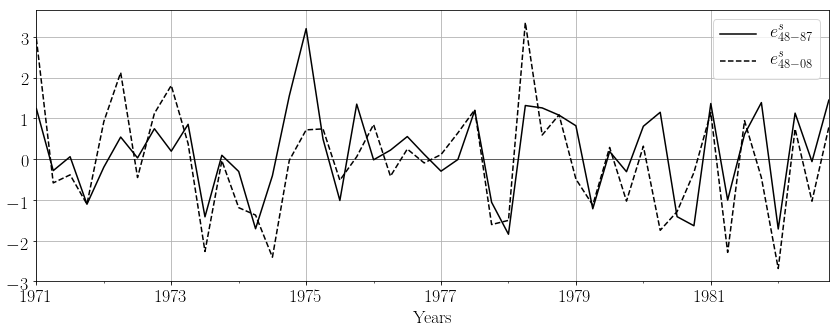

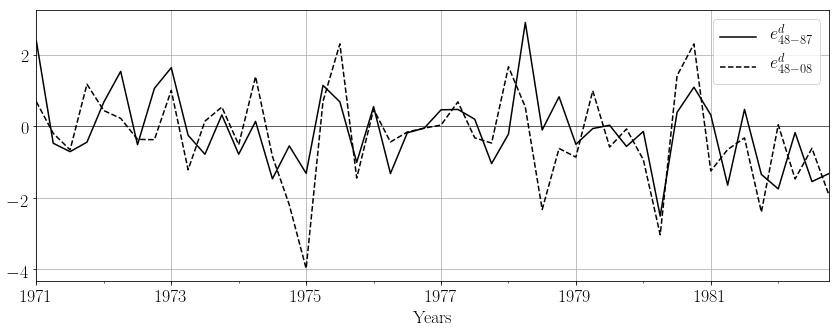

In [17]:
'''Output'''

q13 = pd.DataFrame(ETA, index=X.index[num_lags:], columns=["es", "ed"])
q13.index = q13.reset_index()["index"].dt.to_period('Q').values
legend = [[r"$e^s_{48-87}$", r"$e^s_{48-08}$"], [r"$e^d_{48-87}$", r"$e^d_{48-08}$"]]

for i, x in enumerate(["es", "ed"]):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))#; axes = axes.flatten()
    for j, df_x in enumerate([q12, q13]):
        df_x.loc["1971":"1982", x].plot(color="k", linestyle=["-", "--"][j], ax=ax)
    ax.legend(legend[i])
    ax.set_xlabel('Years')
    #ax.set_title("Structural Shocks: %s-%s" % (x[0], x[1]))
    ax.grid()
    ax.axhline(y=0, color="k", linewidth=0.5)
    plt.tight_layout()
    plt.savefig('./ps1/q13a%s.png' % (i+1), bbox_inches='tight')
    plt.show()

## *1.3.b.*

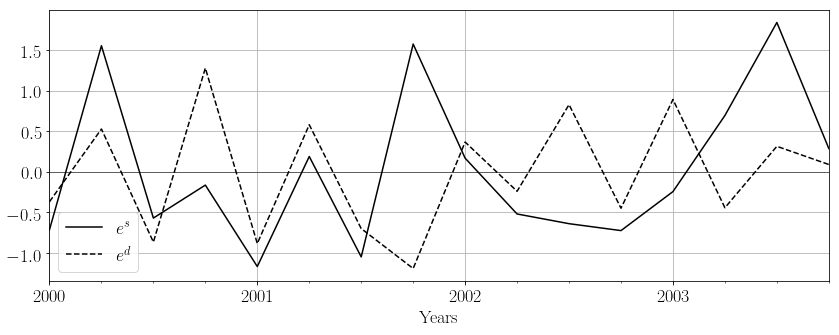

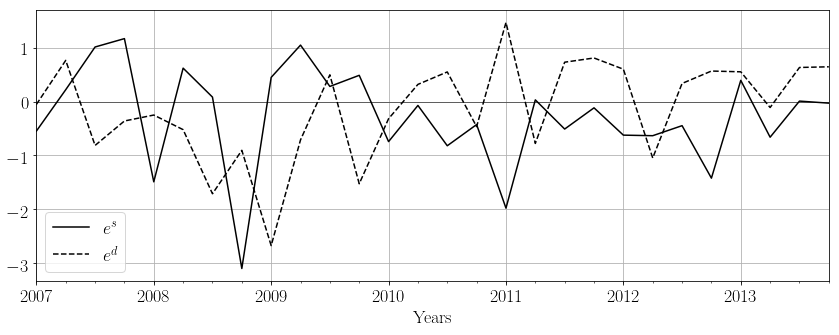

\begin{tabular}{lrr}
\toprule
{} &        es &        ed \\
\midrule
2000Q1 & -0.713553 & -0.368511 \\
2000Q2 &  1.554962 &  0.528503 \\
2000Q3 & -0.569597 & -0.865891 \\
2000Q4 & -0.163351 &  1.279672 \\
2001Q1 & -1.167518 & -0.883934 \\
2001Q2 &  0.189539 &  0.581239 \\
2001Q3 & -1.048656 & -0.699452 \\
2001Q4 &  1.575797 & -1.191533 \\
2002Q1 &  0.168783 &  0.367615 \\
2002Q2 & -0.519287 & -0.239497 \\
2002Q3 & -0.638962 &  0.828783 \\
2002Q4 & -0.724173 & -0.448291 \\
2003Q1 & -0.243487 &  0.892254 \\
2003Q2 &  0.694752 & -0.442469 \\
2003Q3 &  1.841795 &  0.314947 \\
2003Q4 &  0.287691 &  0.090697 \\
\bottomrule
\end{tabular}
 

\begin{tabular}{lrr}
\toprule
{} &        es &        ed \\
\midrule
2007Q1 & -0.547701 & -0.053350 \\
2007Q2 &  0.219829 &  0.764413 \\
2007Q3 &  1.012621 & -0.813800 \\
2007Q4 &  1.167955 & -0.360379 \\
2008Q1 & -1.488878 & -0.249943 \\
2008Q2 &  0.620330 & -0.520980 \\
2008Q3 &  0.082950 & -1.710301 \\
2008Q4 & -3.097063 & -0.904517 \\
2009Q1 &  0.44875

In [18]:
'''Output'''

for i, x in enumerate([['2000', '2003'], ['2007', '2013']]):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))#; axes = axes.flatten()
    q13.loc[x[0]:x[1]].plot(color="k", style=["-", "--"], ax=ax)
    ax.legend(["$e^s$", "$e^d$"])
    ax.set_xlabel('Years')
    #ax.set_title("Structural Shocks: %s-%s" % (x[0], x[1]))
    ax.grid()
    ax.axhline(y=0, color="k", linewidth=0.5)
    plt.tight_layout()
    plt.savefig('./ps1/q13b%s.png' % (i+1), bbox_inches='tight')
    plt.show()

print(q13.loc["2000":"2003"].to_latex(), "\n")
print(q13.loc["2007":"2013"].to_latex())

****

# *1.4*

In [19]:
'''IRFs are stored in a 3-dimensional array. Dimension 1 is time. Dimension
    2 is variable, and 3 is shock. So IRF(:,2,1) gives the impulse response
    of the second variable to the first shock. IRF_sum gives the integrated
    responses (i.e, in levels). IRF_sum(:,1,1) gives the cumulative impulse
    response of variable 1 to shock 1.'''

# number of periods for IRFS and VARDEC
num_impulses = 40
IRF          = np.zeros([num_impulses,num_vars,num_vars])
Temp         = np.identity(c_Bhat.shape[0])

psi  = []
for t in range(num_impulses):
    psi_t = Temp[:num_vars,:num_vars] 
    IRF[t,:,:] = psi_t@A0                    # store the IRF
    Temp = c_Bhat@Temp                       # computes the exponent of the matrix
    #psi.append(psi_t)                       # stores the matrices Psi (notations as in Hamilton)

irf         = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
irf.columns = ["s_y","d_y","s_u","d_u"]
irf_cum     = irf.cumsum()                   #output is expressed cumulatively

irf_final   = pd.concat([irf_cum["s_y"],     #supply shock on output
                         irf_cum["d_y"],     #demand shock on output
                         irf["s_u"],         #supply shock on unemployment
                         irf["d_u"]],axis=1) #demand shock on unemployment

In [20]:
'''Vfrac_D(:,1,1) : variance of the first variable explained by varshock
   Vfrac_D(:,2,2) : variance of the second variable explained by varshock
   Vfrac_L : same for levels (cumulative response)'''

MSE1_D = np.zeros([num_impulses,num_vars,num_vars]) 
MSE2_D = np.zeros([num_impulses,num_vars,num_vars]) 
MSE1_t = np.zeros([num_vars,num_vars]) 
MSE2_t = np.zeros([num_vars,num_vars]) 
g1 = A0[:,:1] 
g2 = A0[:,1:2] 
Temp = np.identity(c_Bhat.shape[0])               # for i=1, Temp is Identity.
for t in range(num_impulses): 
    Psi_t = Temp[:num_vars,:num_vars]    # extracts the upper left block.
    
    MSE1_t = MSE1_t + np.dot(np.dot(Psi_t,g1),np.dot(g1.T,Psi_t.T))                        
    MSE2_t = MSE2_t + np.dot(np.dot(Psi_t,g2),np.dot(g2.T,Psi_t.T))
    MSE1_D[t,:,:] = MSE1_t 
    MSE2_D[t,:,:] = MSE2_t 
    Temp = np.dot(c_Bhat,Temp)

Vfrac_D1 = MSE1_D/(MSE1_D+MSE2_D)
Vfrac_D2 = MSE2_D/(MSE1_D+MSE2_D)

vfrac_D1 = pd.DataFrame({i:Vfrac_D1[i].flatten() for i in range(num_impulses)}).T #save Vardec into dataframe
vfrac_D1.columns = ["vs_dy","","","vs_u"]
vfrac_D1_final   = pd.concat([vfrac_D1["vs_dy"],        #supply shock on variance of growth of output
                              vfrac_D1["vs_u"]],axis=1) #supply shock on variance of unemployment

vfrac_D2 = pd.DataFrame({i:Vfrac_D2[i].flatten() for i in range(num_impulses)}).T #save Vardec into dataframe
vfrac_D2.columns = ["vd_dy","","","vd_u"]
vfrac_D2_final   = pd.concat([vfrac_D2["vd_dy"],     #demand shock on variance of growth of output
                           vfrac_D2["vd_u"]],axis=1) #demand shock on variance of unemployment
vfrac_final      = pd.concat([vfrac_D1["vs_dy"], vfrac_D1["vs_u"],
                              vfrac_D2["vd_dy"],vfrac_D2["vd_u"]],axis=1)

In [21]:
'''Vfrac_D(:,1,1) : variance of the first variable explained by varshock
   Vfrac_D(:,2,2) : variance of the second variable explained by varshock
   Vfrac_L : same for levels (cumulative response)'''

MSE1_L = np.zeros([num_impulses,num_vars,num_vars]) 
MSE2_L = np.zeros([num_impulses,num_vars,num_vars]) 
MSE1_t = np.zeros([num_vars,num_vars]) 
MSE2_t = np.zeros([num_vars,num_vars]) 
g1 = A0[:,:1] 
g2 = A0[:,1:2] 
Temp = np.identity(c_Bhat.shape[0])      # for i=1, Temp is Identity.
for t in range(num_impulses): 
    Psi_t = Temp[:num_vars,:num_vars]    # extracts the upper left block.
    
    MSE1_t = MSE1_t + np.dot(np.dot(Psi_t,g1),np.dot(g1.T,Psi_t.T))                        
    MSE2_t = MSE2_t + np.dot(np.dot(Psi_t,g2),np.dot(g2.T,Psi_t.T))
    MSE1_L[t,:,:] = MSE1_t 
    MSE2_L[t,:,:] = MSE2_t 
    Temp = np.identity(c_Bhat.shape[0]) + np.dot(c_Bhat,Temp)

Vfrac_L1 = MSE1_L/(MSE1_L+MSE2_L)
Vfrac_L2 =MSE2_L/(MSE1_L+MSE2_L)

vfrac_L1 = pd.DataFrame({i:Vfrac_L1[i].flatten() for i in range(num_impulses)}).T #save vardec into dataframe
vfrac_L1.columns = ["vs_y","","",""]
vfrac_L1_final = vfrac_L1["vs_y"] #supply shock on variance of output
                         
vfrac_L2 = pd.DataFrame({i:Vfrac_L2[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
vfrac_L2.columns = ["vd_y","","",""]
vfrac_L2_final = vfrac_L2["vd_y"] #demand shock on on variance of output
                          
vfrac_final_L=pd.concat([vfrac_L1["vs_y"],vfrac_L2["vd_y"]],axis=1)

A0_hat = np.vstack((A0,np.zeros([(num_lags-1)*num_vars,num_vars])))

In [22]:
'''Simulation'''

# simulation
#shut down a shock
ETA_D = ETA.copy()
ETA_D[:,0]=np.zeros((num_obs))
ETA_S = ETA.copy()
ETA_S[:,1]=np.zeros((num_obs))
ETA_DS = ETA.copy()
ETA_DS[:,0]=np.zeros((num_obs))
ETA_DS[:,1]=np.zeros((num_obs))
X_sim = np.zeros([num_vars,num_lags])

for i in range(num_lags):
    X_sim[:,num_lags-1-i]=X.iloc[i,:]
    
X_sim   = np.reshape(X_sim,(num_lags*num_vars,1),order='F')
X_sim   = np.hstack((X_sim,np.zeros([num_lags*num_vars,num_obs-1])))
X_sim_D = X_sim.copy()
X_sim_S = X_sim.copy()
X_sim_DS = X_sim.copy()

for t in range(num_obs-num_lags):
    X_sim[:,t+1]   = np.dot(c_Bhat,X_sim[:,t])   + np.dot(A0_hat,ETA.T[:,t])
    X_sim_D[:,t+1] = np.dot(c_Bhat,X_sim_D[:,t]) + np.dot(A0_hat,ETA_D.T[:,t])
    X_sim_S[:,t+1] = np.dot(c_Bhat,X_sim_S[:,t]) + np.dot(A0_hat,ETA_S.T[:,t])
    X_sim_DS[:,t+1] = np.dot(c_Bhat,X_sim_DS[:,t]) + np.dot(A0_hat,ETA_DS.T[:,t])

In [23]:
def plot_detrended_simulated(detrended, simulated, img_name, label_simulated):
    f, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,10)); axes = axes.flatten()
    index   = detrended.loc["2000":].index[:-1-num_lags]
    label = ["$\widehat{Y}_{historical}^*$", "$u_{historical}^*$"]
    for i, x in enumerate(["dys", "urates"]):
        axes[i].plot(index, detrended[x].values[-len(index)-num_lags-1:-1-num_lags], color="k",linestyle="-")
        axes[i].plot(index, simulated[i,-len(index)-num_lags:-num_lags], color="k",linestyle=":")
        axes[i].legend([label[i], label_simulated[i]])
        axes[i].set_xlabel('Years')
        axes[i].grid()
        plt.tight_layout()
    plt.savefig('./ps1/%s.png'%img_name, bbox_inches='tight')
    plt.show()

In [24]:
plot_detrended_simulated(df, X_sim, "q14w_shocks", ["$\widehat{Y}_{simulated}^*$ w/ shocks", "$u_{simulated}^*$ w/ shocks"])
plot_detrended_simulated(df, X_sim_D, "q14wo_demand", ["$\widehat{Y}_{simulated}^*$ w/o demand shocks", "$u_{simulated}^*$ w/o demand shocks"])
plot_detrended_simulated(df, X_sim_S, "q14wo_supply", ["$\widehat{Y}_{simulated}^*$ w/o supply shocks", "$u_{simulated}^*$ w/o supply shocks"])
plot_detrended_simulated(df, X_sim_DS, "q14wo_shocks", ["$\widehat{Y}_{simulated}^*$ w/o shocks", "$u_{simulated}^*$ w/o shocks"])

****

# *1.5*

## Statsmodel

In [25]:
VAR(X3).fit(10,trend='nc').summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 16, Apr, 2019
Time:                     15:59:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.268423
Nobs:                     263.000    HQIC:                 -0.593380
Log likelihood:          -599.621    FPE:                   0.444357
AIC:                    -0.811716    Det(Omega_mle):        0.383769
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
L1.y1          0.111861         0.081384            1.374           0.169
L1.y2         -3.621987         1.014034           -3.572           0.000
L2.y1          0.124605         0.084777            1.470           0.142
L2.y2          6.

## ML reduced form VAR [ Hamilton (pp 292-300) ]

In [26]:
#VAR with OLS
x, xₗ, βₕ, ε, Ωₕ = [i.copy() for i in [X3, XLAG3, Bhat, EPS, Omegahat]]
xₗ[:,0] = 1

In [27]:
[i.shape for i in [x, xₗ, βₕ, ε, Ωₕ]]

[(273, 2), (273, 20), (20, 2), (273, 2), (2, 2)]

In [28]:
n, p, T = 2, 10, x.shape[0]

In [29]:
def neg_loglike(θ, endog, exog):
    
    Σ = np.sum([(x[i,:].T-βₕ.T@xₗ[i]) for t in range(T)])
    
    #log likelihhod    
    ll = "time out"
    
    pass
    
    return(ll)

In [30]:
neg_loglike(1, 2, 3)

'time out'

In [31]:
"""
#                       alpha  beta  theta1 theta0 gamma1 gamma0 eps_std eta_std v_std        
theta_start = np.array([ 0.05, 0.5,  0.05,   0.5,  0.991,   0.2,     0.1,   .1,     .1])

# Nelder-Mead, BFGS, 
res = minimize(neg_loglike, theta_start,args=(endog,exog),method="BFGS",options={'disp': True,'maxiter':10000})
"""

'\n#                       alpha  beta  theta1 theta0 gamma1 gamma0 eps_std eta_std v_std        \ntheta_start = np.array([ 0.05, 0.5,  0.05,   0.5,  0.991,   0.2,     0.1,   .1,     .1])\n\n# Nelder-Mead, BFGS, \nres = minimize(neg_loglike, theta_start,args=(endog,exog),method="BFGS",options={\'disp\': True,\'maxiter\':10000})\n'